In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif
from data_analysis import run_tsne, plot_tsne

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, ConfusionMatrixDisplay, balanced_accuracy_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
import shap

In [23]:
%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
data_source = 'C:/Users/BiSBII/Documents/MM_ML/data/'

In [4]:
dataset_file = os.path.join(data_source, 'fluxomics_fc.csv')
metadata_file = os.path.join(data_source, 'GSE98923_metadata.xlsx')

In [5]:
metadata = pd.read_excel(metadata_file, index_col=0, sheet_name='NO_REPLICATES')

In [6]:
y_state = metadata['state']
y_cv = metadata['cultivar']

In [7]:
data = pd.read_csv(dataset_file, index_col=0)
data.shape

(8632, 73)

In [8]:
data = data.transpose()
data.shape

(73, 8632)

In [9]:
data = data.fillna(0)
data.shape

(73, 8632)

In [10]:
y_state.sort_index(key=lambda column: column.map(lambda e: list(data.index).index(e)), inplace=True)

# UNSUPERVISED ANALYSIS

apply variance threshold and scaling to all dataset

In [34]:
vt = VarianceThreshold(0)
data_filtered = vt.fit_transform(data)
cols_inds = vt.get_support(indices=True)
df_data_filtered = pd.DataFrame(data_filtered, index=data.index, columns=data.columns[cols_inds])
df_data_filtered.shape

(73, 2322)

In [35]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_data_filtered)
df_data_scaled = pd.DataFrame(data_scaled, columns=df_data_filtered.columns,
                              index=df_data_filtered.index)
df_data_scaled.shape

(73, 2322)

run tsne and plot the results

In [36]:
df_tsne = run_tsne(n_components=2, data=df_data_scaled)

In [37]:
df_tsne['factor'] = y_state

C:\Users\BiSBII\anaconda3\envs\multiomics\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\BiSBII\anaconda3\envs\multiomics\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\BiSBII\anaconda3\envs\multiomics\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\BiSBII\anaconda3\envs\multiomics\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use 

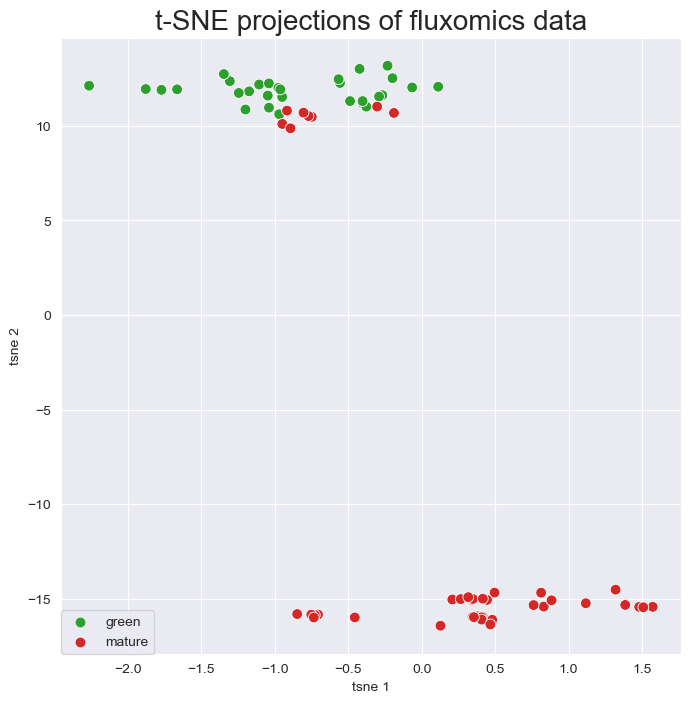

In [38]:
plot_tsne(data=df_tsne, name_fig='tsne_fluxes_state_fc', title='t-SNE projections of fluxomics data')

plot cluster mapping

In [ ]:
lut = {'green': 'g', 'mature': 'r'}
row_colors = y_state.map(lut)
sns.clustermap(df_data_scaled, row_colors=row_colors, figsize=(20, 15))

plot cluster mapping with correlations

In [ ]:
lut = {'green': 'g', 'mature': 'r'}
row_colors = y_state.map(lut)
sns.clustermap(df_data_scaled, metric='correlation', row_colors=row_colors, figsize=(20, 15))

# SUPERVISED ANALYSIS

In [12]:
binary = {'green': 0, 'mature': 1}
binary_output = y_state.map(binary)
binary_output

MEAN SAMPLES
CS_time0_2012     0
CS_time0_2013     0
CS_time0_2014     0
CS_time10_2012    1
CS_time10_2013    1
                 ..
PN_time8_2013     1
PN_time8_2014     1
PN_time9_2012     1
PN_time9_2013     1
PN_time9_2014     1
Name: state, Length: 73, dtype: int64

## train_test_split

In [79]:
Xtrain, Xtest, y_train, y_test = train_test_split(data, y_state, test_size=0.30, stratify=y_state)

### Variance threshold

In [139]:
# remove some features
vt = VarianceThreshold(0.0001)
filter_train = vt.fit(Xtrain)

train_filtered = filter_train.transform(Xtrain)
test_filtered = filter_train.transform(Xtest)

cols_inds = vt.get_support(indices=True)

X_train_filtered = pd.DataFrame(train_filtered, index=Xtrain.index, columns=Xtrain.columns[cols_inds])
print(X_train_filtered.shape)

X_test_filtered = pd.DataFrame(test_filtered, index=Xtest.index, columns=Xtest.columns[cols_inds])
X_test_filtered.shape

(51, 1301)


(22, 1301)

### Select KBEST

In [140]:
kb2 = SelectKBest(f_classif, k=500)

kb2_fit = kb2.fit(X_train_filtered, y_train)

train_filtered2 = kb2_fit.transform(X_train_filtered)
test_filtered2 = kb2_fit.transform(X_test_filtered)

cols_inds = kb2_fit.get_support(indices=True)

X_train_filtered2 = pd.DataFrame(train_filtered2, columns=X_train_filtered.columns[cols_inds], index=X_train_filtered.index)
print(X_train_filtered2.shape)

X_test_filtered2 = pd.DataFrame(test_filtered2, columns=X_test_filtered.columns[cols_inds], index=X_test_filtered.index)
X_test_filtered2.shape

(51, 500)


(22, 500)

### scaling

In [83]:
scaler_model = StandardScaler().fit(X_train_filtered2)
X_train_scaled = scaler_model.transform(X_train_filtered2)
X_test_scaled = scaler_model.transform(X_test_filtered2)
X_train_final = pd.DataFrame(X_train_scaled, columns=X_train_filtered2.columns, index=X_train_filtered2.index)
X_test_final = pd.DataFrame(X_test_scaled, columns=X_test_filtered2.columns, index=X_test_filtered2.index)

X_train_final.shape

(51, 500)

### LR

In [ ]:
lr = LogisticRegression(random_state=0).fit(X_train_final, y_train)
y_pred_lr = lr.predict(X_test_final)

print('Accuracy: %0.2f' % accuracy_score(y_test, y_pred_lr))
print('Precision: %0.2f' % precision_score(y_test, y_pred_lr, average='weighted'))
print('Recall: %0.2f' % recall_score(y_test, y_pred_lr, average='weighted'))
print('F1 score: %0.2f' % f1_score(y_test, y_pred_lr, average='weighted'))

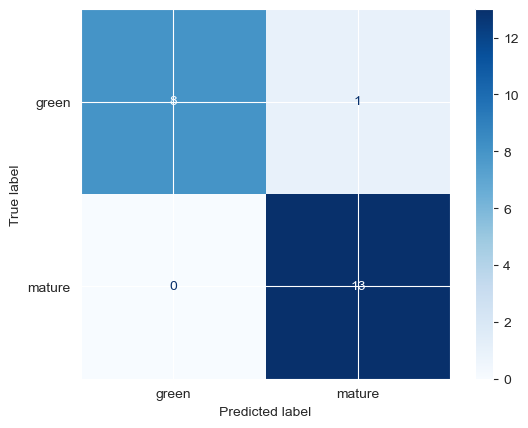

In [85]:
lr_cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr, display_labels=lr.classes_, cmap='Blues')
lr_cm

### KNN

In [86]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_final, y_train)

y_pred_knn = knn.predict(X_test_final.values)

print('Accuracy: %0.2f' % accuracy_score(y_test, y_pred_knn))
print('Precision: %0.2f' % precision_score(y_test, y_pred_knn, average='weighted'))
print('Recall: %0.2f' % recall_score(y_test, y_pred_knn, average='weighted'))
print('F1 score: %0.2f' % f1_score(y_test, y_pred_knn, average='weighted'))

Accuracy: 0.95
Precision: 0.96
Recall: 0.95
F1 score: 0.95


C:\Users\BiSBII\anaconda3\envs\multiomics\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


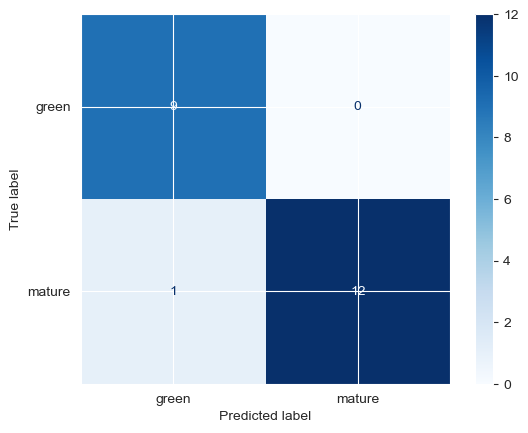

In [66]:
knn_cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_knn, display_labels=knn.classes_, cmap='Blues')
knn_cm

### DT

In [87]:
clf_tree = tree.DecisionTreeClassifier()
clf_tree = clf_tree.fit(X_train_final, y_train)

y_pred_tree = clf_tree.predict(X_test_final)

print('Accuracy: %0.2f' % accuracy_score(y_test, y_pred_tree))
print('Precision: %0.2f' % precision_score(y_test, y_pred_tree, average='weighted'))
print('Recall: %0.2f' % recall_score(y_test, y_pred_tree, average='weighted'))
print('F1 score: %0.2f' % f1_score(y_test, y_pred_tree, average='weighted'))

Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 score: 1.00


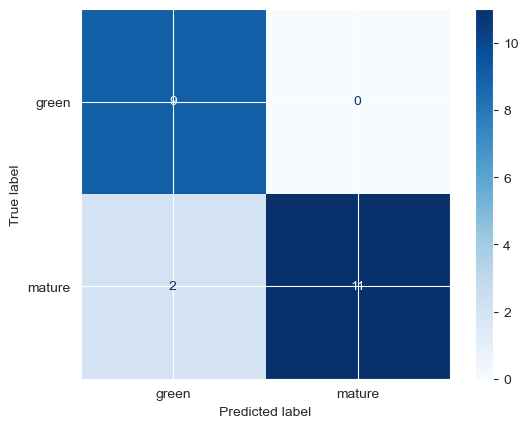

In [70]:
dt_cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_tree, display_labels=clf_tree.classes_, cmap='Blues')
dt_cm

### SVM

In [88]:
svm_model = svm.SVC()
svm_model.fit(X_train_final, y_train)

svm_y_pred = svm_model.predict(X_test_final)

print('Accuracy: %0.2f' % accuracy_score(y_test, svm_y_pred))
print('Precision: %0.2f' % precision_score(y_test, svm_y_pred, average='weighted'))
print('Recall: %0.2f' % recall_score(y_test, svm_y_pred, average='weighted'))
print('F1 score: %0.2f' % f1_score(y_test, svm_y_pred, average='weighted'))

Accuracy: 0.95
Precision: 0.96
Recall: 0.95
F1 score: 0.95


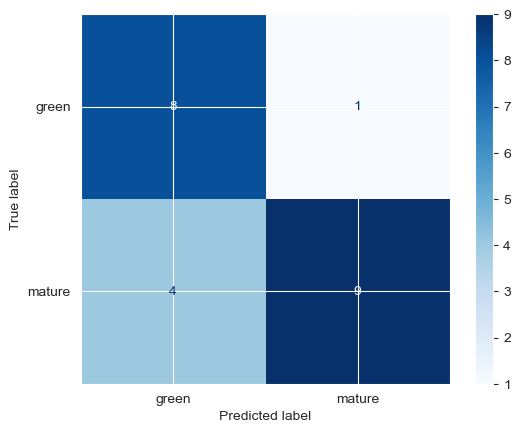

In [76]:
svm_cm = ConfusionMatrixDisplay.from_predictions(y_test, svm_y_pred, display_labels=svm_model.classes_, cmap='Blues')
svm_cm

### RANDOM FOREST

In [89]:
rf_model = RandomForestClassifier(n_estimators=10)
rf_model.fit(X_train_final, y_train)
 
rf_y_pred = rf_model.predict(X_test_final)

print('Accuracy: %0.2f' % accuracy_score(y_test, rf_y_pred))
print('Precision: %0.2f' % precision_score(y_test, rf_y_pred, average='weighted'))
print('Recall: %0.2f' % recall_score(y_test, rf_y_pred, average='weighted'))
print('F1 score: %0.2f' % f1_score(y_test, rf_y_pred, average='weighted'))

Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 score: 1.00


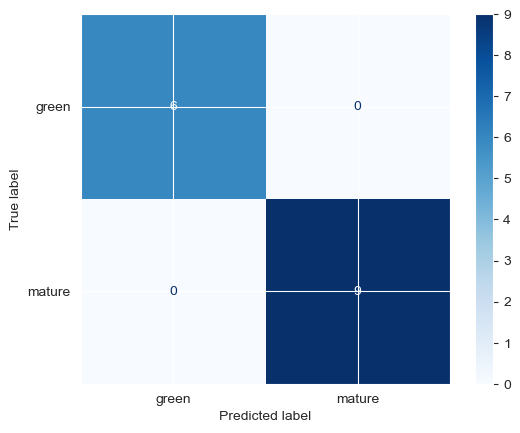

In [57]:
rf_cm = ConfusionMatrixDisplay.from_predictions(y_test, rf_y_pred, display_labels=rf_model.classes_, cmap='Blues')
rf_cm

# CROSS VALIDATION

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate, LeaveOneOut

In [12]:
binary = {'green': 0, 'mature': 1}
binary_output = y_state.map(binary)
binary_output

MEAN SAMPLES
CS_time0_2012     0
CS_time0_2013     0
CS_time0_2014     0
CS_time10_2012    1
CS_time10_2013    1
                 ..
PN_time8_2013     1
PN_time8_2014     1
PN_time9_2012     1
PN_time9_2013     1
PN_time9_2014     1
Name: state, Length: 73, dtype: int64

In [22]:
scaler = StandardScaler()
vt = VarianceThreshold(0.001)
skb = SelectKBest(f_classif, k=500)
scoring = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1']
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

CV -> LR

In [44]:
lr_cv = LogisticRegression()

pipe_lr = Pipeline([('transformer1', vt), ('transformer2', skb), ('transformer3', scaler), ('estimator', lr_cv)])

scores_lr = cross_validate(pipe_lr, data, binary_output, cv=cv, scoring=scoring, return_estimator=True)

print('test_accuracy', round(scores_lr['test_accuracy'].mean(), 2))
print('test_balanced_accuracy', round(scores_lr['test_balanced_accuracy'].mean(), 2))
print('test_precision', round(scores_lr['test_precision'].mean(), 2))
print('test_recall', round(scores_lr['test_recall'].mean(), 2))
print('test_f1', round(scores_lr['test_f1'].mean(), 2))

test_accuracy 0.97
test_balanced_accuracy 0.97
test_precision 0.96
test_recall 1.0
test_f1 0.98


Feature importance LR

In [45]:
dfs_lr = []

for idx,estimator in enumerate(scores_lr['estimator']):
    
    feature_importances_lr = pd.DataFrame(estimator.steps[3][1].coef_.transpose(),
                                          index = data.columns[estimator.steps[1][1].get_support(indices=True)],
                                          columns=['importance']).sort_values('importance', ascending=False)

    dfs_lr.append(feature_importances_lr)

complete_df_importance_lr = pd.concat(dfs_lr, axis=1)
complete_df_importance_lr.to_csv(os.path.join(data_source, 'LR_features_cv.csv'))
complete_df_importance_lr = complete_df_importance_lr.fillna(0)
complete_df_importance_lr['mean'] = abs(complete_df_importance_lr).mean(axis=1)

complete_df_importance_lr = abs(complete_df_importance_lr).sort_values(by=['mean'], ascending=False)
complete_df_importance_lr['mean']

RXN-6883__mito                      0.273896
RXNQT-4366__cyto                    0.272563
RXN-11530__er                       0.232260
RXN-11388__er                       0.178202
THREONINE--TRNA-LIGASE-RXN__chlo    0.178202
                                      ...   
TR1000084__vacu__cyto               0.000364
RXN-5985__mito                      0.000364
RXN-17741__er                       0.000344
TI0000239__vacu__cyto               0.000344
METHYLVALERATE-RXN__chlo            0.000316
Name: mean, Length: 1081, dtype: float64

<Axes: >

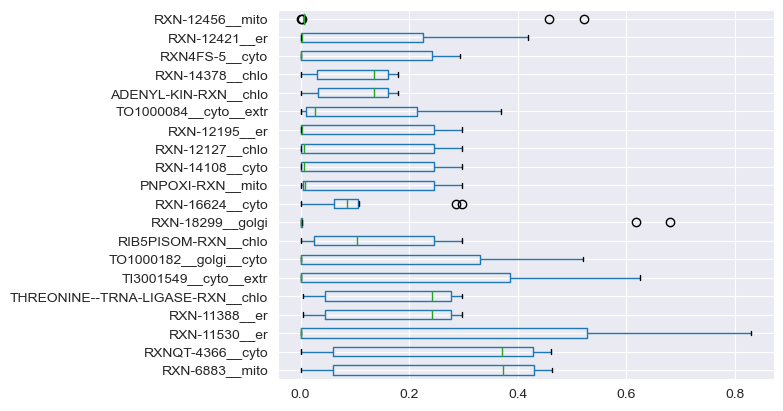

In [46]:
complete_df_importance_lr.iloc[:20, :-1].transpose().boxplot(vert=False)

CV -> RF

In [47]:
subdata_lr = data[complete_df_importance_lr.iloc[:10, -1].index]
group_df_lr = subdata_lr.groupby(y_state).mean()
maxvals_lr = group_df_lr.idxmax()
colours = {'green': 'g', 'mature': 'r'}
colours_map_lr = maxvals_lr.map(colours)
colours_map_lr

(73, 10)

<BarContainer object of 10 artists>

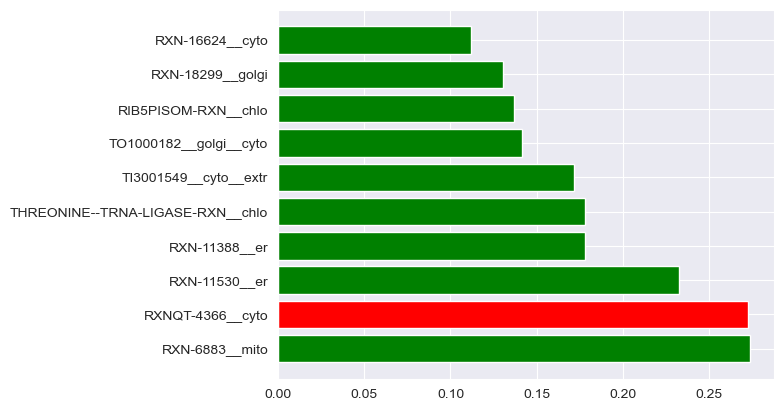

In [52]:
plt.barh(complete_df_importance_lr.iloc[:10, -1].index, complete_df_importance_lr.iloc[:10, -1], color=colours_map_lr)

In [21]:
rf_cv = RandomForestClassifier(random_state=42)

pipe_rf = Pipeline([('transformer1', vt), ('transformer2', skb), ('transformer3', scaler), ('estimator', rf_cv)])

scores_rf = cross_validate(pipe_rf, data, binary_output, cv=cv, scoring=scoring, return_estimator=True)

print('test_accuracy', round(scores_rf['test_accuracy'].mean(), 2))
print('test_balanced_accuracy', round(scores_rf['test_balanced_accuracy'].mean(), 2))
print('test_precision', round(scores_rf['test_precision'].mean(), 2))
print('test_recall', round(scores_rf['test_recall'].mean(), 2))
print('test_f1', round(scores_rf['test_f1'].mean(), 2))

test_accuracy 0.97
test_balanced_accuracy 0.97
test_precision 0.98
test_recall 0.98
test_f1 0.97


RF feature importance

In [22]:
dfs_rf = []

for idx,estimator in enumerate(scores_rf['estimator']):
    
    feature_importances_rf = pd.DataFrame(estimator.steps[3][1].feature_importances_,
                                          index = data.columns[estimator.steps[1][1].get_support(indices=True)],
                                          columns=['importance']).sort_values('importance', ascending=False)
    
    dfs_rf.append(feature_importances_rf)
 
    # feature_importances_rf.to_csv(os.path.join(data_source, 'RF_features_cv' + str(idx) + '.csv'))

complete_df_importance_rf = pd.concat(dfs_rf, axis=1)
# complete_df_importance_rf.to_csv(os.path.join(data_source, 'RF_features_cv.csv'))
complete_df_importance_rf = complete_df_importance_rf.fillna(0)
complete_df_importance_rf['mean'] = complete_df_importance_rf.mean(axis=1)

complete_df_importance_rf = complete_df_importance_rf.sort_values(by=['mean'], ascending=False)
complete_df_importance_rf['mean']

RXN-11388__er                                  0.035602
RXNQT-4366__cyto                               0.021796
THREONINE--TRNA-LIGASE-RXN__chlo               0.020127
RXN-2947__cyto                                 0.017520
TI3000278__cyto__extr                          0.016370
                                                 ...   
HYDROXYBENZALDEHYDE-OXIDATION-NAD-RXN__cyto    0.000000
RXN-9944__chlo                                 0.000000
1.1.1.34-RXN__cyto                             0.000000
RXN0-7280__cyto                                0.000000
RXN-12669__pero                                0.000000
Name: mean, Length: 1081, dtype: float64

<Axes: >

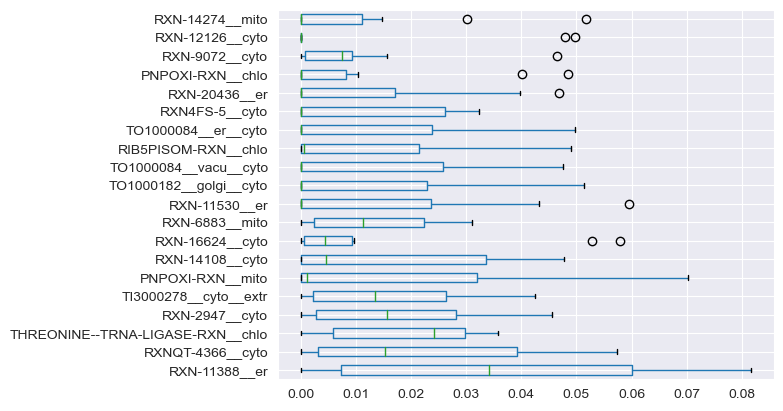

In [38]:
complete_df_importance_rf.iloc[:20, :-1].transpose().boxplot(vert=False)

In [39]:
subdata = data[complete_df_importance_rf.iloc[:20, -1].index]
group_df = subdata.groupby(y_state).mean()
maxvals = group_df.idxmax()
colours_map = maxvals.map(colours)
colours_map

(73, 20)

<BarContainer object of 10 artists>

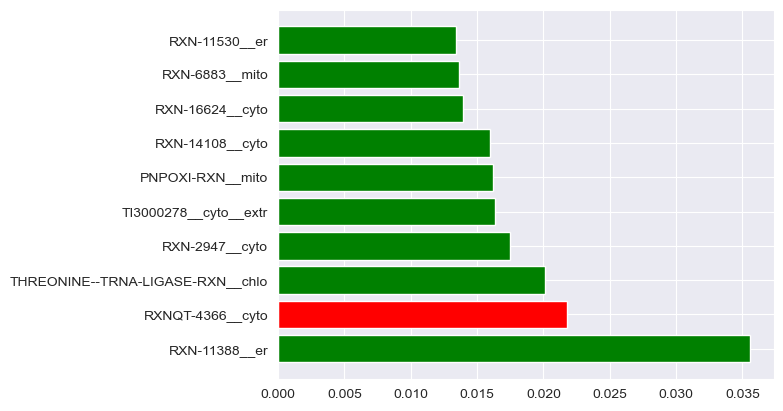

In [43]:
plt.barh(complete_df_importance_rf.iloc[:10, -1].index, complete_df_importance_rf.iloc[:10, -1], color=colours_map)

CV - KNN

In [23]:
knn_cv = KNeighborsClassifier()

pipe_knn = Pipeline([('transformer1', vt), ('transformer2', skb), ('transformer3', scaler), ('estimator', knn_cv)])

scores_knn = cross_validate(pipe_knn, data, binary_output, cv=cv, scoring=scoring)
for key in scores_knn:
    print(key, round(scores_knn[key].mean(), 2))

fit_time 0.07
score_time 0.05
test_accuracy 0.96
test_balanced_accuracy 0.95
test_precision 0.96
test_recall 0.98
test_f1 0.97


CV - DT

In [25]:
tree_cv = tree.DecisionTreeClassifier(random_state=1)

pipe_tree = Pipeline([('transformer1', vt), ('transformer2', skb), ('transformer3', scaler), ('estimator', tree_cv)])

scoring = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1']

scores_tree = cross_validate(pipe_tree, data, binary_output, cv=cv, scoring=scoring)
for key in scores_tree:
    print(key, round(scores_tree[key].mean(), 2))

fit_time 0.07
score_time 0.04
test_accuracy 0.96
test_balanced_accuracy 0.96
test_precision 0.98
test_recall 0.95
test_f1 0.96


CV - SVM

In [27]:
svm_cv = svm.SVC()

pipe_svm = Pipeline([('transformer1', vt), ('transformer2', skb), ('transformer3', scaler), ('estimator', svm_cv)])

scoring = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1']

scores_svm = cross_validate(pipe_svm, data, binary_output, cv=cv, scoring=scoring)
for key in scores_svm:
    print(key, round(scores_svm[key].mean(), 2))

fit_time 0.07
score_time 0.04
test_accuracy 0.96
test_balanced_accuracy 0.95
test_precision 0.96
test_recall 0.98
test_f1 0.97


CV - SVM LINEAR

In [26]:
svm_l_cv = svm.SVC(kernel='linear')

pipe_svm_l = Pipeline([('transformer1', vt), ('transformer2', skb), ('transformer3', scaler), ('estimator', svm_l_cv)])

scoring = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1']

scores_svm_l = cross_validate(pipe_svm_l, data, binary_output, cv=cv, scoring=scoring, return_estimator=True)

print('test_accuracy', round(scores_svm_l['test_accuracy'].mean(), 2))
print('test_balanced_accuracy', round(scores_svm_l['test_balanced_accuracy'].mean(), 2))
print('test_precision', round(scores_svm_l['test_precision'].mean(), 2))
print('test_recall', round(scores_svm_l['test_recall'].mean(), 2))
print('test_f1', round(scores_svm_l['test_f1'].mean(), 2))

test_accuracy 0.96
test_balanced_accuracy 0.95
test_precision 0.96
test_recall 0.98
test_f1 0.97


In [54]:
dfs_svm = []

for idx,estimator in enumerate(scores_svm_l['estimator']):
    
    feature_importances_svm = pd.DataFrame(estimator.steps[3][1].coef_.transpose(),
                                          index = data.columns[estimator.steps[1][1].get_support(indices=True)],
                                          columns=['importance']).sort_values('importance', ascending=False)

    dfs_svm.append(feature_importances_svm)

complete_df_importance_svm = pd.concat(dfs_svm, axis=1)
complete_df_importance_svm.to_csv(os.path.join(data_source, 'SVM_features_cv.csv'))
complete_df_importance_svm = complete_df_importance_svm.fillna(0)
complete_df_importance_svm['mean'] = abs(complete_df_importance_svm).mean(axis=1)

complete_df_importance_svm = complete_df_importance_svm.sort_values(by=['mean'], ascending=False)
complete_df_importance_svm['mean']

RXN-6883__mito                         1.585542e-01
RXNQT-4366__cyto                       1.577845e-01
TI3001549__cyto__extr                  1.449062e-01
RXN-11530__er                          1.445693e-01
RXN-18299__golgi                       1.055737e-01
                                           ...     
TO1000119__vacu__cyto                  1.080053e-11
TRYPTOPHAN--TRNA-LIGASE-RXN__cyto      5.819353e-13
DTDPDEHYDRHAMEPIM-RXN__cyto            5.819353e-13
RXN-14448__pero                        5.819353e-13
ACETOACETYL-COA-HYDROLASE-RXN__mito    8.755976e-18
Name: mean, Length: 1081, dtype: float64

<Axes: >

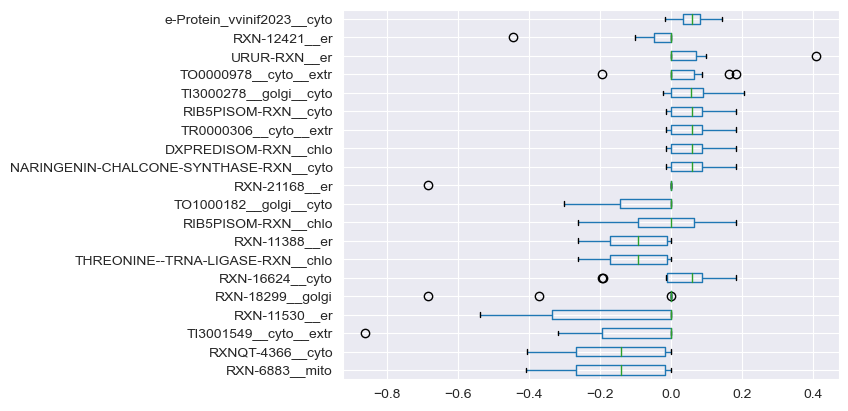

In [288]:
complete_df_importance_svm.iloc[:20, :-1].transpose().boxplot(vert=False)

In [56]:
subdata_svm = data[complete_df_importance_svm.iloc[:20, -1].index]
group_df_svm = subdata_svm.groupby(y_state).mean()
maxvals_svm = group_df_svm.idxmax()
colours_map_svm = maxvals.map(colours)

(73, 20)

<BarContainer object of 10 artists>

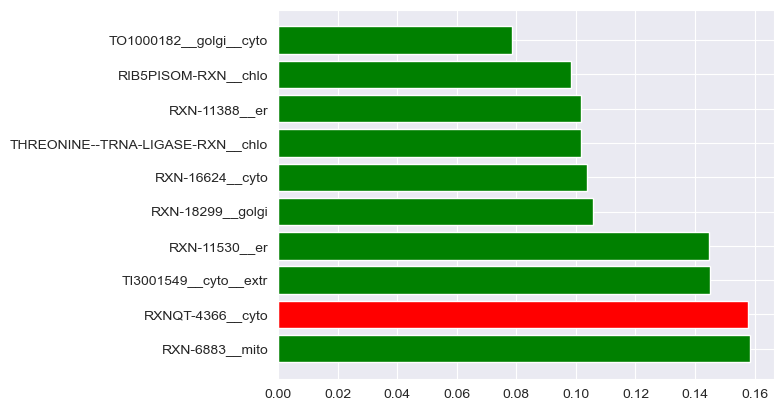

In [60]:
plt.barh(complete_df_importance_svm.iloc[:10, -1].index, complete_df_importance_svm.iloc[:10, -1], color=colours_map_svm)

LOO nao permite calcular outras metricas

In [155]:
loo = LeaveOneOut()

scoring = ['accuracy', 'balanced_accuracy']

scores = cross_validate(pipe_rf, data, binary_output, cv=loo, scoring=scoring)
for key in scores:
    print(key, round(scores[key].mean(), 2))

C:\Users\BiSBII\anaconda3\envs\multiomics\Lib\site-packages\sklearn\metrics\_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\BiSBII\anaconda3\envs\multiomics\Lib\site-packages\sklearn\metrics\_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


fit_time 0.17
score_time 0.04
test_accuracy 0.97
test_balanced_accuracy 0.97


fazer manualmente e ver os resultados - same results

In [299]:

scores = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
for train_index, test_index in cv.split(data, binary_output):
    train = data.iloc[train_index, :]
    test = data.iloc[test_index, :]
    
    y_train = binary_output.iloc[train_index]
    y_test = binary_output.iloc[test_index]
    
    filter_train = vt.fit(train)

    train_filtered = filter_train.transform(train)
    test_filtered = filter_train.transform(test)

    cols_inds = vt.get_support(indices=True)

    X_train_filtered = pd.DataFrame(train_filtered, index=train.index, columns=train.columns[cols_inds])

    X_test_filtered = pd.DataFrame(test_filtered, index=test.index, columns=test.columns[cols_inds])

    kb2_fit = kb2.fit(X_train_filtered, y_train)

    train_filtered2 = kb2_fit.transform(X_train_filtered)
    test_filtered2 = kb2_fit.transform(X_test_filtered)

    cols_inds = kb2_fit.get_support(indices=True)

    X_train_filtered2 = pd.DataFrame(train_filtered2, columns=X_train_filtered.columns[cols_inds], index=X_train_filtered.index)

    X_test_filtered2 = pd.DataFrame(test_filtered2, columns=X_test_filtered.columns[cols_inds], index=X_test_filtered.index)

    scaler_model = StandardScaler().fit(X_train_filtered2)
    X_train_scaled = scaler_model.transform(X_train_filtered2)
    X_test_scaled = scaler_model.transform(X_test_filtered2)
    X_train_final = pd.DataFrame(X_train_scaled, columns=X_train_filtered2.columns, index=X_train_filtered2.index)
    X_test_final = pd.DataFrame(X_test_scaled, columns=X_test_filtered2.columns, index=X_test_filtered2.index)

    rf_model.fit(X_train_final, y_train)

    rf_y_pred = rf_model.predict(X_test_final)

    # print('Accuracy: %0.2f' % accuracy_score(y_test, rf_y_pred))
    # print('Precision: %0.2f' % precision_score(y_test, rf_y_pred, average='weighted'))
    # print('Recall: %0.2f' % recall_score(y_test, rf_y_pred, average='weighted'))
    # print('F1 score: %0.2f' % f1_score(y_test, rf_y_pred, average='weighted'))

    scores['accuracy'].append(accuracy_score(y_test, rf_y_pred))
    scores['precision'].append(precision_score(y_test, rf_y_pred))
    scores['recall'].append(recall_score(y_test, rf_y_pred))
    scores['f1'].append(f1_score(y_test, rf_y_pred))


[0 0 0 1 1 1 1 1] pred
MEAN SAMPLES
CS_time0_2012     0
CS_time0_2013     0
CS_time0_2014     0
CS_time10_2012    1
CS_time10_2013    1
CS_time10_2014    1
CS_time11_2012    1
CS_time11_2013    1
Name: state, dtype: int64 real
[1 1 1 1 1 0 0 0] pred
MEAN SAMPLES
CS_time11_2014    1
CS_time12_2012    1
CS_time12_2013    1
CS_time12_2014    1
CS_time13_2013    1
CS_time1_2012     0
CS_time1_2013     0
CS_time1_2014     0
Name: state, dtype: int64 real
[0 0 0 1 0 0 1 1] pred
MEAN SAMPLES
CS_time2_2012    0
CS_time2_2013    0
CS_time2_2014    0
CS_time5_2012    1
CS_time5_2013    1
CS_time5_2014    1
CS_time6_2012    1
CS_time6_2013    1
Name: state, dtype: int64 real
[0 0 0 1 1 1 1] pred
MEAN SAMPLES
CS_time3_2012    0
CS_time3_2013    0
CS_time3_2014    0
CS_time6_2014    1
CS_time7_2012    1
CS_time7_2013    1
CS_time7_2014    1
Name: state, dtype: int64 real
[0 0 1 1 1 1 1] pred
MEAN SAMPLES
CS_time4_2012    0
CS_time4_2013    0
CS_time4_2014    0
CS_time8_2012    1
CS_time8_2013    1


# Analise manual para retirar shap values (apenas LR e RF - bests results)

## Logistic regression

In [ ]:
scores_lr = {'accuracy': [], 'balanced_accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'shaps': []}

for train_index, test_index in cv.split(data, binary_output):
    
    train = data.iloc[train_index, :]
    test = data.iloc[test_index, :]
    
    y_train = binary_output.iloc[train_index]
    y_test = binary_output.iloc[test_index]
    
    filter_train = vt.fit(train)

    train_filtered = filter_train.transform(train)
    test_filtered = filter_train.transform(test)

    cols_inds = vt.get_support(indices=True)

    X_train_filtered = pd.DataFrame(train_filtered, index=train.index, columns=train.columns[cols_inds])

    X_test_filtered = pd.DataFrame(test_filtered, index=test.index, columns=test.columns[cols_inds])

    kb2_fit = skb.fit(X_train_filtered, y_train)

    train_filtered2 = kb2_fit.transform(X_train_filtered)
    test_filtered2 = kb2_fit.transform(X_test_filtered)

    cols_inds = kb2_fit.get_support(indices=True)

    X_train_filtered2 = pd.DataFrame(train_filtered2, columns=X_train_filtered.columns[cols_inds], index=X_train_filtered.index)

    X_test_filtered2 = pd.DataFrame(test_filtered2, columns=X_test_filtered.columns[cols_inds], index=X_test_filtered.index)

    scaler_model = StandardScaler().fit(X_train_filtered2)
    X_train_scaled = scaler_model.transform(X_train_filtered2)
    X_test_scaled = scaler_model.transform(X_test_filtered2)
    X_train_final = pd.DataFrame(X_train_scaled, columns=X_train_filtered2.columns, index=X_train_filtered2.index)
    X_test_final = pd.DataFrame(X_test_scaled, columns=X_test_filtered2.columns, index=X_test_filtered2.index)

    lr = LogisticRegression()

    lr.fit(X_train_final, y_train)

    lr_y_pred = lr.predict(X_test_final)

    scores_lr['accuracy'].append(accuracy_score(y_test, lr_y_pred))
    scores_lr['balanced_accuracy'].append(balanced_accuracy_score(y_test, lr_y_pred))
    scores_lr['precision'].append(precision_score(y_test, lr_y_pred))
    scores_lr['recall'].append(recall_score(y_test, lr_y_pred))
    scores_lr['f1'].append(f1_score(y_test, lr_y_pred))

    explainer_lr = shap.Explainer(lr.predict, X_test_final, max_evals=1100)
    shap_values_lr = explainer_lr(X_test_final)

    scores_lr['shaps'].append(shap_values_lr)

print('accuracy', round(np.array(scores_lr['accuracy']).mean(), 3))
print('balanced_accuracy', round(np.array(scores_lr['balanced_accuracy']).mean(), 3))
print('precision', round(np.array(scores_lr['precision']).mean(), 3))
print('recall', round(np.array(scores_lr['recall']).mean(), 3))
print('f1', round(np.array(scores_lr['f1']).mean(), 3))

## RANDOM FORESTS

In [ ]:
scores_rf = {'accuracy': [], 'balanced_accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'shaps': []}

for train_index, test_index in skf.split(data, binary_output):
    train = data.iloc[train_index, :]
    test = data.iloc[test_index, :]
    
    y_train = binary_output.iloc[train_index]
    y_test = binary_output.iloc[test_index]
    
    filter_train = vt.fit(train)

    train_filtered = filter_train.transform(train)
    test_filtered = filter_train.transform(test)

    cols_inds = vt.get_support(indices=True)

    X_train_filtered = pd.DataFrame(train_filtered, index=train.index, columns=train.columns[cols_inds])

    X_test_filtered = pd.DataFrame(test_filtered, index=test.index, columns=test.columns[cols_inds])

    kb2_fit = skb.fit(X_train_filtered, y_train)

    train_filtered2 = kb2_fit.transform(X_train_filtered)
    test_filtered2 = kb2_fit.transform(X_test_filtered)

    cols_inds = kb2_fit.get_support(indices=True)

    X_train_filtered2 = pd.DataFrame(train_filtered2, columns=X_train_filtered.columns[cols_inds], index=X_train_filtered.index)

    X_test_filtered2 = pd.DataFrame(test_filtered2, columns=X_test_filtered.columns[cols_inds], index=X_test_filtered.index)

    scaler_model = StandardScaler().fit(X_train_filtered2)
    X_train_scaled = scaler_model.transform(X_train_filtered2)
    X_test_scaled = scaler_model.transform(X_test_filtered2)
    X_train_final = pd.DataFrame(X_train_scaled, columns=X_train_filtered2.columns, index=X_train_filtered2.index)
    X_test_final = pd.DataFrame(X_test_scaled, columns=X_test_filtered2.columns, index=X_test_filtered2.index)

    rf = RandomForestClassifier(random_state=5)

    rf.fit(X_train_final, y_train)

    rf_y_pred = rf.predict(X_test_final)

    scores_rf['accuracy'].append(accuracy_score(y_test, rf_y_pred))
    scores_rf['balanced_accuracy'].append(balanced_accuracy_score(y_test, rf_y_pred))
    scores_rf['precision'].append(precision_score(y_test, rf_y_pred))
    scores_rf['recall'].append(recall_score(y_test, rf_y_pred))
    scores_rf['f1'].append(f1_score(y_test, rf_y_pred))
     
    explainer = shap.Explainer(rf.predict, X_test_final, max_evals=1100)
    shap_values = explainer(X_test_final)

    scores_rf['shaps'].append(shap_values)

print('accuracy', round(np.array(scores_rf['accuracy']).mean(), 2))
print('balanced_accuracy', round(np.array(scores_rf['balanced_accuracy']).mean(), 2))
print('precision', round(np.array(scores_rf['precision']).mean(), 2))
print('recall', round(np.array(scores_rf['recall']).mean(), 2))
print('f1', round(np.array(scores_rf['f1']).mean(), 2))